# Pipeline Baseline: YOLO → Pinhole → ResNet → 6D Pose
Questa versione minimale esegue la pipeline base per la stima della posa 6D su LineMOD, ispirata al notebook test5_baseline_pinhole_pipeline.ipynb.

**Nota:** Questa pipeline minimale esegue solo un batch di test e mostra la traduzione e la rotazione predette. Per valutazioni complete e metriche, vedere il notebook originale test5_baseline_pinhole_pipeline.ipynb.

## 1. Import essenziali e setup minimal

In [1]:
# Import essenziali e setup minimal
import sys
from pathlib import Path
import torch
import os
import pandas as pd

sys.path.insert(0, str(Path.cwd().parent))
from config import Config
from models.pose_estimator_baseline import PoseEstimatorBaseline
from models.yolo_detector import YOLODetector
from utils.pinhole import compute_translation_pinhole
from dataset.linemod_pose import create_pose_dataloaders
from utils.validation import load_validation_results, calc_add_accuracy_per_class, calc_pinhole_error_per_class, run_pinhole_deep_pipeline
from utils.visualization import plot_add_per_class


Cache Strategy: full


## 2. Carica modelli pre-addestrati (YOLO e PoseEstimatorBaseline)

In [2]:
# Carica modelli pre-addestrati (YOLO e PoseEstimatorBaseline)
yolo_weights = Config.CHECKPOINT_DIR / 'pretrained' / 'yolo11n.pt'
yolo_detector = YOLODetector(model_name=str(yolo_weights), num_classes=Config.NUM_CLASSES) if yolo_weights.exists() else None
pose_ckpt = Config.CHECKPOINT_DIR / 'pose' / 'test_rotationonly_1' / 'weights' / 'best.pt'
model_baseline = PoseEstimatorBaseline(pretrained=True).to(Config.DEVICE)
if pose_ckpt.exists():
    model_baseline.load_state_dict(torch.load(pose_ckpt, map_location=Config.DEVICE))
model_baseline.eval()

✅ Loading custom weights from: /Users/nicolotermine/zMellow/GitHub-Poli/Polito/polito-aml-6D_pose_estimation/checkpoints/pretrained/yolo11n.pt
PoseEstimatorBaseline initialized (BASELINE MODEL)
   Backbone: resnet50 (weights=ResNet50_Weights.IMAGENET1K_V1, frozen=False)
   Feature dim: 2048
   Output: 4 values (quaternion only)
   Translation: Computed with Pinhole Camera Model (NOT learned)
   Dropout: 0.5


PoseEstimatorBaseline(
  (backbone): Sequential(
    (0): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
    (3): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (4): Sequential(
      (0): Bottleneck(
        (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu): ReLU(inplace=True)
        (downsample): Sequential(
          (

## 3. Carica un batch di test e applica la pipeline minimale

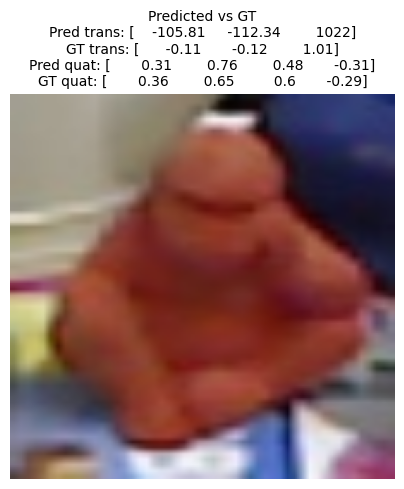

In [9]:
# Carica un batch di test e applica la pipeline minimale
train_loader, val_loader, test_loader = create_pose_dataloaders(
    dataset_root=Config.LINEMOD_ROOT,
    batch_size=1,
    crop_margin=Config.POSE_CROP_MARGIN,
    output_size=Config.POSE_IMAGE_SIZE,
    num_workers=Config.NUM_WORKERS_POSE
)
batch = next(iter(test_loader))
image = batch['rgb_crop'].to(Config.DEVICE)
bbox = batch['bbox'][0].cpu().numpy()
depth_path = batch['depth_path'][0]
# Carica parametri intrinseci della camera per la scena corrente
from utils.pinhole import load_camera_intrinsics
info_yml_path = Path(depth_path).parent.parent / 'info.yml'
camera_intrinsics = load_camera_intrinsics(info_yml_path)
# Usa il metodo corretto per la detection con YOLODetector
if yolo_detector:
    # detect_objects restituisce una lista di detection, qui si assume un solo oggetto per semplicità
    img_np = image.cpu().numpy()[0].transpose(1, 2, 0)  # [3, H, W] → [H, W, 3]
    detections = yolo_detector.detect_objects(img_np)
    if detections and 'bbox' in detections[0]:
        det = detections[0]['bbox']
    else:
        det = bbox  # fallback se detection fallisce
else:
    det = bbox  # fallback: usa bbox GT
translation = compute_translation_pinhole(det, depth_path, camera_intrinsics)
rotation = model_baseline(image).cpu().detach().numpy()

# Ricava la ground truth della traslazione (se disponibile)
gt_translation = None
if 'translation' in batch:
    gt_translation = batch['translation'][0].cpu().numpy()

# Visualizza l'immagine con GT e predizione a confronto
import matplotlib.pyplot as plt
import numpy as np

img_vis = image.cpu().numpy()[0].transpose(1, 2, 0)
mean = np.array([0.485, 0.456, 0.406])
std = np.array([0.229, 0.224, 0.225])
img_vis = img_vis * std + mean
img_vis = np.clip(img_vis, 0, 1)

gt_quat = batch['quaternion'][0].cpu().numpy() if 'quaternion' in batch else None
fig, ax = plt.subplots(figsize=(5, 5))
ax.imshow(img_vis)
ax.axis('off')
title = "Predicted vs GT\n"
title += f"Pred trans: {np.round(translation,2)}\n"
if gt_translation is not None:
    title += f"GT trans: {np.round(gt_translation,2)}\n"
title += f"Pred quat: {np.round(rotation[0],2)}"
if gt_quat is not None:
    title += f"\nGT quat: {np.round(gt_quat,2)}"
ax.set_title(title, fontsize=10)
plt.show()

## 4. Esegui la pipeline baseline su tutto il test set e salva le metriche (ADD rot-only, errore pinhole)

In [ ]:
# Esegui la pipeline baseline su tutto il test set e salva le metriche (ADD rot-only, errore pinhole)
run_pinhole_deep_pipeline(model_baseline, test_loader, name='test_rotationonly_1')

## 5. Carica e mostra tabella delle metriche per classe (ADD rot-only, errore pinhole)

In [ ]:
# Carica e mostra tabella delle metriche per classe (ADD rot-only, errore pinhole)
val_csv_path = os.path.join(Config.CHECKPOINT_DIR, 'pose', 'test_rotationonly_1', 'validation_result.csv')
results_rot_only, results_pinhole = load_validation_results(val_csv_path)

data, global_add, global_acc = calc_add_accuracy_per_class(results_rot_only, Config.LINEMOD_OBJECTS)

df = pd.DataFrame(data)
display(df)
print(f"\nMedia globale ADD (rot-only): {global_add:.2f}")
print(f"Accuracy globale (rot-only) (%): {global_acc:.1f}")

if results_pinhole is not None:
    data_pinhole, global_pinhole = calc_pinhole_error_per_class(results_pinhole, Config.LINEMOD_OBJECTS)
    df_pinhole = pd.DataFrame(data_pinhole)
    display(df_pinhole)
    print(f"\nErrore medio pinhole globale (mm): {global_pinhole:.2f}")

## 6. Grafico a barre delle medie ADD per classe (rot-only)
Mostra le medie della metrica ADD per ciascuna classe oggetto, calcolate sulla rotazione predetta.

In [ ]:
# Grafico a barre delle medie ADD per classe (rot-only)
results_rot_only = globals().get('results_rot_only', None)
if results_rot_only is None:
    print("⚠️  Devi prima calcolare la metrica ADD rot-only su tutto il test set e salvare i risultati in 'results_rot_only'.")
else:
    plot_add_per_class(results_rot_only, Config.LINEMOD_OBJECTS)